# Ridge Regression

This tutorial builds upon the work performed in the previous tutorial "*Least_Squares_Regression.ipynb*". The data used will be the same

### Learning Objectives

- Test both Python and mathematical competencies in ridge regression
- Calculate ridge regression weights using linear algebra
- Understand how to standardize data and its working 
- Process data for regularized methods 
- Implement ridge regression from scratch
- Familiarize with the concept of hyperparameter tuning

Before coding an algorithm, we will take a look at our data using Python's `pandas`. For visualizations, we'll use `matplotlib`.
Let's import the necessary libraries and load the datasets by using the pandas pd.read_csv() function.

In [1]:
### Import the necessary modules

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)  

### Read in the data
tr_path = 'data/train.csv'

data = pd.read_csv(tr_path)

We begin by performing some basic exploratory data analysis by using the function head() and the attribute columns.


In [2]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Next, let's plot the relationship between our variables of interest: the price for each house and the above ground living area in square feet.

We can do so by creating a scatter plot using matplotlib.

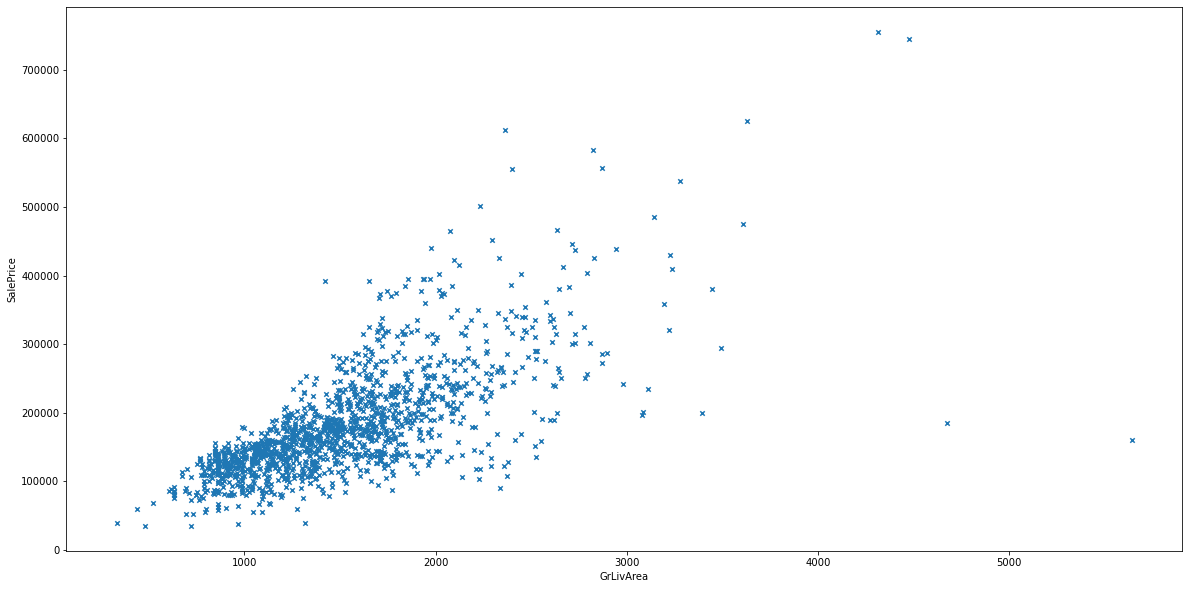

In [3]:
data.plot('GrLivArea', 'SalePrice', kind = 'scatter', marker = 'x');

### Coding Ridge Regression   

#### Preprocessing
Before implementing ridge regression, it is important to mean-center our target variable and mean-center and standardize observations. We will do this by using the following formulas:  
#### Mean Center Target
$$y_{cent} = y_0 - \bar{y}$$

#### Standardize Observations
$$X_{std} = \frac{X_0-\bar{X}}{s_{X}}$$

Where $\bar{X}$ is the sample mean of X and $s_{X}$ is the sample standard deviation of X. 

We will create a function called "standardize" that accepts, as input a list of numbers and returns a list where those values have been standardized.

In [6]:
def standardize( num_list):
    
    output = []
    x_mean = np.mean(num_list)
    x_std = np.std(num_list)
    for x in num_list:
        x_standard = (x - x_mean) / x_std
        output.append(x_standard)
    return output

Below we will create a function which will preprocess our data by performing:
* mean subtraction from $y$,
* dimension standardization for $x$.

The formulas to Mean Center Target and Standardize Observations are given above.

In [7]:
def preprocess_for_regularization(data, y_column_name, x_column_names):
    
    df = data.copy()
    df = df.loc[:, x_column_names + [y_column_name]]
    
    for x in x_column_names:
        df[x] = standardize(df[x])
        
    y_mean = df[y_column_name].mean()
    df[y_column_name] = df[y_column_name].apply(lambda z: z - y_mean)
    return df

Then we will test our function

In [8]:
data = pd.read_csv(tr_path).head()
prepro_data = preprocess_for_regularization(data,'SalePrice', ['GrLivArea','YearBuilt'])

print(prepro_data)

   GrLivArea  YearBuilt  SalePrice
0  -0.082772   0.716753     7800.0
1  -1.590161  -0.089594   -19200.0
2   0.172946   0.657024    22800.0
3  -0.059219  -1.911342   -60700.0
4   1.559205   0.627159    49300.0


Next, we will implement the equation for ridge regression using the closed form equation:  

$$w_{RR}=(\lambda+X^TX)^{-1}X^Ty$$

We will create a  function called "ridge_regression_weights" that takes, as input, three inputs: two matricies corresponding to the x inputs and y target and a number (int or float) for the lambda parameter

The function should return a numpy array of regression weights

 The following steps must be accomplished:

Ensure the number of rows of each the X matrix is greater than the number of columns.
If not, transpose the matrix.
Ultimately, the y input will have length n. Thus the x input should be in the shape n-by-p

*Prepend* an n-by-1 column of ones to the input_x matrix

We will use the above equation to calculate the least squares weights. This will involve creating the lambda matrix - a p+1-by-p+1 matrix with the "lambda_param" on the diagonal

In [9]:
def ridge_regression_weights(input_x, output_y, lambda_param):
    
    if input_x.shape[0] < input_x.shape[1]:
        input_x = input_x.T
          
    ones_matrix = np.ones((input_x.shape[0], 1), dtype=int)
    input_x = np.concatenate((ones_matrix, input_x), axis=1)
    lambda_matrix = lambda_param * np.identity(min(input_x.shape))
    
    weights = np.matmul(np.linalg.inv(lambda_matrix + np.matmul(input_x.T, input_x)), np.matmul(input_x.T, output_y))
   
    return weights

### Selecting the $\lambda$ parameter

For our final function before looking at the `sklearn` implementation of ridge regression, we will create a hyperparameter tuning algorithm.

In ridge regression, we must pick a value for $\lambda$. We have some intuition about $\lambda$ from the equations that define it: small values tend to emulate the results from Least Squares, while large values will reduce the dimensionality of the problem.

For this tutorial, we will solve a simple problem on finding a value that minimizes the list returned by the function.

In [10]:
### `hidden` takes a single number as a parameter (int or float) and returns a list of 1000 numbers
### the input must be between 0 and 50 exclusive

def hidden(hp):
    if (hp<=0) or (hp >= 50):
        print("input out of bounds")
    
    nums = np.logspace(0,5,num = 1000)
    vals = nums** 43.123985172351235134687934
    
    user_vals = nums** hp
    
    return vals-user_vals

In [11]:
hidden(10)

array([0.00000000e+000, 5.21602216e-001, 1.44269840e+000, 3.02824512e+000,
       5.71471536e+000, 1.02206282e+001, 1.77282466e+001, 3.01822582e+001,
       5.07807508e+001, 8.47822724e+001, 1.40832459e+002, 2.33144706e+002,
       3.85084668e+002, 6.35062327e+002, 1.04621709e+003, 1.72233776e+003,
       2.83403092e+003, 4.66173544e+003, 7.66642746e+003, 1.26058419e+004,
       2.07255113e+004, 3.40727870e+004, 5.60130097e+004, 9.20779670e+004,
       1.51360544e+005, 2.48807182e+005, 4.08986104e+005, 6.72281340e+005,
       1.10507416e+006, 1.81647877e+006, 2.98585170e+006, 4.90801023e+006,
       8.06756031e+006, 1.32610730e+007, 2.17979119e+007, 3.58303436e+007,
       5.88961561e+007, 9.68105887e+007, 1.59132441e+008, 2.61573989e+008,
       4.29962286e+008, 7.06750554e+008, 1.16172127e+009, 1.90957938e+009,
       3.13887116e+009, 5.15951950e+009, 8.48096019e+009, 1.39405783e+010,
       2.29148254e+010, 3.76662441e+010, 6.19138882e+010, 1.01770953e+011,
       1.67286003e+011, 2

The below function will be similar to `hidden` created above. Like 'hidden', the passed function will take a single argument, a number between 0 and 50 exclusive and then, the function will return a numpy array of 1000 numbers.

Your function should return the value that makes the mean of the array returned by 'passed_func' as close to 0 as possible.

In [12]:
def minimize( passed_func):
    # Create values to test
    test_vals = list(np.linspace(.1,49.9, 1000))
    
    # Find mean of returned array from function
    ret_vals = [abs(np.mean(passed_func(x))) for x in test_vals]
    
    # Find smallest mean
    min_mean = min(ret_vals)
    
    # Return the test value that creates the smallest mean
    return test_vals[ret_vals.index(min_mean)] 
    

In the case of ridge regression, you would be searching lambda parameters to minimize the validation error.

See below for an example of using the functions built above that automatically perform hyperparameter tuning using mean absolute deviation.

In [15]:
def lambda_search_func(lambda_param):
    
    # Define X and y
    # with preprocessing
    df = preprocess_for_regularization(data.head(50),'SalePrice', ['GrLivArea','YearBuilt'])
    
    y_true = df['SalePrice'].values
    X = df[['GrLivArea','YearBuilt']].values
    
    # Calculate Weights then use for predictions
    weights = ridge_regression_weights(X, y_true, lambda_param )
    y_pred = weights[0] + np.matmul(X,weights[1:])
    
    # Calculate Residuals
    resid = y_true - y_pred
    
    # take absolute value to tune on mean-absolute-deviation
    # Alternatively, could use:
    # return resid **2-S
    # for tuning on mean-squared-error
    
    return abs(resid)

In [14]:
minimize(lambda_search_func)

0.1

### Ridge Regression in `sklearn` 

In the below code, I will show you how to implement Ridge regression in `sklearn`.

We will use the function `LinearRegression` from `sklearn` to instantiate the classifier `lr`.
We will use the function `Ridge` from `sklear` to instantiate the classifier `reg`. For this classifier, set the parameter `alpha=100000`. Use the `Ridge` function to instantiate another classifier, `reg0`, but, this time, set `alpha=0`.

**NOTE: Note, the "alpha" parameter defines regularization strength. Lambda is a reserved word in `Python` -- Thus "alpha" instead**

In [17]:
from sklearn.linear_model import Ridge, LinearRegression

lr = LinearRegression()
reg = Ridge(alpha=100000)
reg0 = Ridge(alpha=0)
X = data[['GrLivArea', 'YearBuilt']]
y = data['SalePrice']

for m, name in zip([lr, reg, reg0], ["LeastSquares","Ridge alpha = 100000","Ridge, alpha = 0"]):
    m.fit(X,y)
    print(name, "Intercept:", m.intercept_, "Coefs:",m.coef_,"\n")

LeastSquares Intercept: -1657495.3815412046 Coefs: [ 50.96078156 894.28944409] 

Ridge alpha = 100000 Intercept: 2426.370526011393 Coefs: [61.61957348 46.17903856] 

Ridge, alpha = 0 Intercept: -1657495.381541204 Coefs: [ 50.96078156 894.28944409] 

